In [2]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.devices import MockDevice
from pulser.waveforms import RampWaveform, ConstantWaveform

import matplotlib.pyplot as plt

import qutip

In [3]:
# Define a dictionary where each key is the name of the qubit,
# and each value is the qubit's position (in um)

qubit_positions = {
    'q0': (0, 0),
    'q1': (3, 5.2),
    'q2': (6, 0),
    'q3': (9, -5.2),
    'q4': (9, 0),
    'q5': (9, 5.2),
    'q6': (9, 10.4),
    'q7': (12, 0),
}

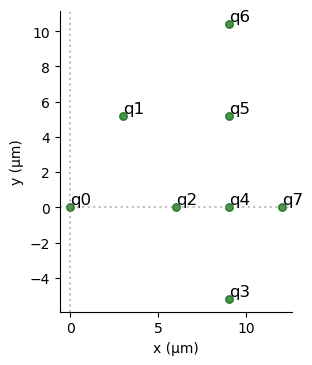

In [7]:
# Arrangements of qubits on the machine are called a register
# Define a register in Pulser by passing the qubit dictionary

reg = Register(qubit_positions)
reg.draw()

In [8]:
# Define the maximum Rabi frequency by imposing a blockade radius
# (units are um for the blockade radius and rad/us for the rabi frequency)

blockade_radius = 8.7
Omega_max = MockDevice.rabi_from_blockade(blockade_radius)
print(Omega_max)

12.499610303500795


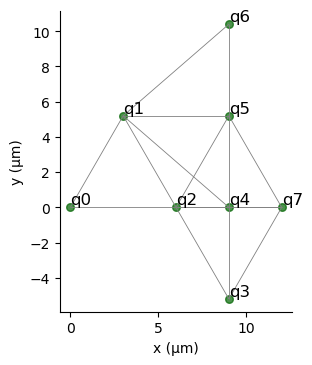

In [9]:
# Visualize the edges induced by the chosen blockade radius

reg.draw(blockade_radius=blockade_radius)

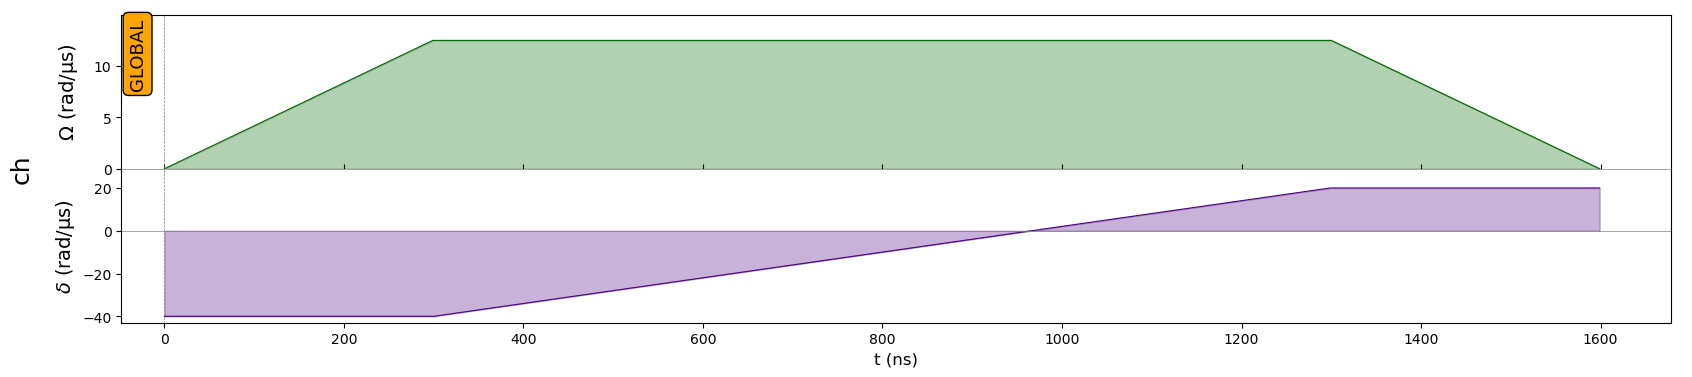

In [10]:
# Create the sequence

seq = Sequence(reg, MockDevice)
seq.declare_channel('ch', 'rydberg_global')

# First ramp
omega_wf_1 = RampWaveform(300, 0, Omega_max)
delta_wf_1 = ConstantWaveform(300, -40)
first_pulse = Pulse(omega_wf_1, delta_wf_1, 0)
seq.add(first_pulse, 'ch')

# Middle part
omega_wf_2 = ConstantWaveform(1000, Omega_max)
delta_wf_2 = RampWaveform(1000, -40, 20)
middle_pulse = Pulse(omega_wf_2, delta_wf_2, 0)
seq.add(middle_pulse, 'ch')

# Final ramp
omega_wf_3 = RampWaveform(300, Omega_max, 0)
delta_wf_3 = ConstantWaveform(300, 20)
final_pulse = Pulse(omega_wf_3, delta_wf_3, 0)
seq.add(final_pulse, 'ch')

seq.draw()

In [11]:
# The sequence is ready now for simulation

sim = Simulation(seq)
results = sim.run()
samples = results.sample_final_state(10000)
print(samples)

Counter({'10010010': 5890, '10000011': 3151, '10000010': 268, '00010010': 192, '00000011': 106, '01010010': 88, '10001010': 73, '10000001': 60, '01010000': 43, '10010000': 30, '01000001': 29, '01000011': 23, '00001010': 14, '00000010': 11, '00100010': 8, '10000000': 4, '00000001': 2, '01000010': 2, '10000100': 2, '10010100': 2, '01000000': 1, '01001000': 1})


In [12]:
# Isolate the best bitstring

best_bitstring = max(samples, key=samples.get)
print(best_bitstring)


10010010


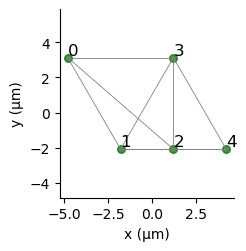

In [13]:
# Create a new register by deleting previous solution

old_coords = reg._coords
new_coords = [p for i, p in enumerate(old_coords) if best_bitstring[i]=='0']
new_reg = Register.from_coordinates(new_coords)
new_reg.draw(blockade_radius=blockade_radius)

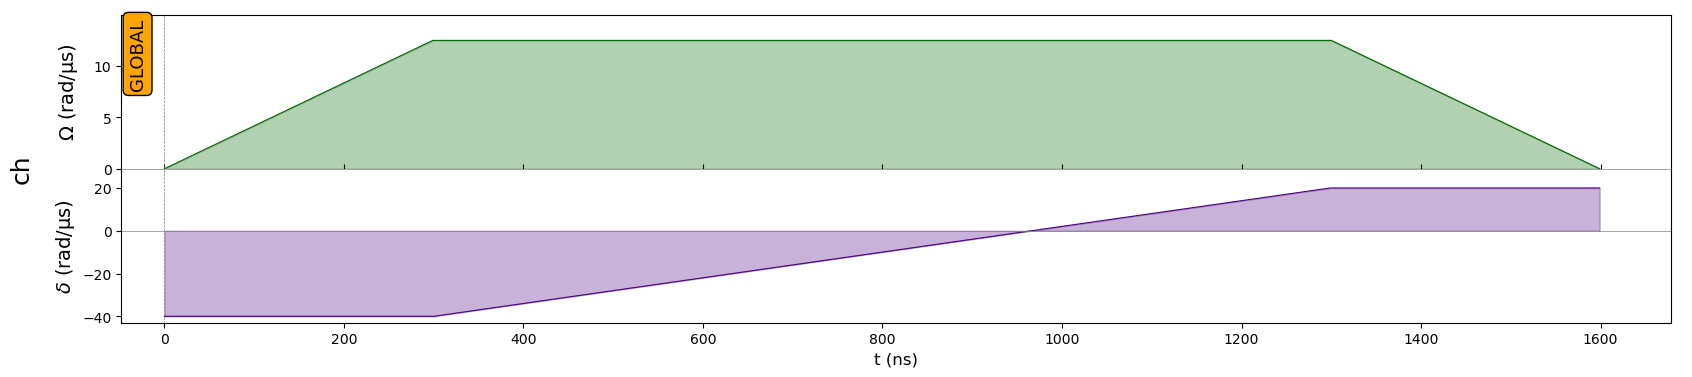

In [14]:
# Create the new sequence

new_seq = Sequence(new_reg, MockDevice)
new_seq.declare_channel('ch', 'rydberg_global')

# First ramp
new_seq.add(first_pulse, 'ch')

# Middle part
new_seq.add(middle_pulse, 'ch')

# Final ramp
new_seq.add(final_pulse, 'ch')

new_seq.draw()

In [15]:
# The new sequence is ready now for simulation

new_sim = Simulation(new_seq)
new_results = new_sim.run()
new_samples = new_results.sample_final_state(10000)
print(new_samples)

Counter({'10001': 8728, '00001': 284, '10100': 282, '00100': 260, '00010': 201, '01000': 155, '10000': 73, '00000': 17})


In [23]:
# But of course the proper way is to automatize the process

def coloring(register, blockade_radius):

    solutions = []
    
    coords = register._coords
    ids = register.qubit_ids
    while len(coords) > 0:
        reg = Register.from_coordinates(coords, labels=ids)

        # Create sequence
        seq = Sequence(reg, MockDevice)
        seq.declare_channel('ch', 'rydberg_global')


        # Add pulses
        Omega_max = MockDevice.rabi_from_blockade(blockade_radius)
        
        # First ramp
        omega_wf_1 = RampWaveform(300, 0, Omega_max)
        delta_wf_1 = ConstantWaveform(300, -40)
        first_pulse = Pulse(omega_wf_1, delta_wf_1, 0)
        seq.add(first_pulse, 'ch')

        # Middle part
        omega_wf_2 = ConstantWaveform(1000, Omega_max)
        delta_wf_2 = RampWaveform(1000, -40, 20)
        middle_pulse = Pulse(omega_wf_2, delta_wf_2, 0)
        seq.add(middle_pulse, 'ch')

        # Final ramp
        omega_wf_3 = RampWaveform(300, Omega_max, 0)
        delta_wf_3 = ConstantWaveform(300, 20)
        final_pulse = Pulse(omega_wf_3, delta_wf_3, 0)
        seq.add(final_pulse, 'ch')


        # Simulate    
        sim = Simulation(seq)
        results = sim.run()
        samples = results.sample_final_state(10000)

        # Save best solution and prepare next iteration
        best_bitstring = max(samples, key=samples.get)
        best_ids = [ids[i] for i in range(len(best_bitstring)) if best_bitstring[i]=='1'] 
        solutions.append(' '.join(best_ids))
        
        ids = [ids[i] for i in range(len(best_bitstring)) if best_bitstring[i]=='0'] 
        coords = [p for i, p in enumerate(coords) if best_bitstring[i]=='0']

    return solutions

    
    
    

In [24]:
coloring(reg, blockade_radius)

['q0 q3 q6', 'q1 q7', 'q5', 'q4', 'q2']